In [2]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import graphviz

from IPython.display import Image

%matplotlib inline

# Load Data

In [3]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [4]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

In [6]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return entropy: entropy value
    '''
    #Initialize entropy, determine unique labels and n
    entropy = 0
    unique_classes = np.unique(label_array)
    n = float(len(label_array))
    
    #Loop through each unique label
    for label_i in unique_classes:
        ent_i = np.sum(label_array == label_i) / n
        entropy = entropy + -ent_i*np.log(ent_i)
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    #Initialize gini, determine unique labels and n
    gini = 0
    unique_classes = np.unique(label_array)
    n = len(label_array)
    
    #Loop through each unique label
    for label_i in unique_classes:
        gini_i = np.sum(label_array == label_i) / n
        gini = gini + gini_i * (1 - gini_i)
    return gini

In [7]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method for splitting node
        :param leaf_value_estimator: method for estimating leaf value
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth

    def fit(self, X, y=None):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        #Calculate length of X
        n = len(X)
        
        #Determine whether or not at a leaf
        leaf_status = (self.depth == self.max_depth) or (n <= self.min_sample)
        self.is_leaf = leaf_status
        
        #Determine leaf value if at leaf
        if self.is_leaf:
            self.value = self.leaf_value_estimator(y)
            
        #Otherwise, find best split
        else:
            self.find_best_feature_split(X, y)
            
            #Initialize lists for X/y right/left
            X_right = []
            X_left = []
            y_right = []
            y_left = []
            
            #Calculate values for decision tree call
            depth_i = self.depth + 1
            min_sample = self.min_sample
            max_depth = self.max_depth
            
            #Call decision tree method for left branch
            self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator,
                                         depth_i, min_sample, max_depth)
            
            #Call decision tree method for right branch
            self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator,
                                         depth_i, min_sample, max_depth)

            #Loop through all values in X
            for i in range(n):
                
                #Add to left branch 
                if(X[i][self.split_id]<self.split_value):
                    X_left.append(X[i])
                    y_left.append(y[i])
                
                #Add to right branch
                else:
                    X_right.append(X[i])
                    y_right.append(y[i])
            
            #Fit model
            self.left.fit(np.array(X_left),np.array(y_left))
            self.right.fit(np.array(X_right),np.array(y_right))        
        
        return self
        
    def find_best_split(self, x_node, y_node, feature_id):
        '''
        For feature number feature_id, returns the optimal splitting point 
        for data X_node, y_node, and corresponding loss
        :param X: a numpy array of training data, shape = (n_node)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        #Initialize loss
        loss = []
        
        #Get list of values for X
        X_values = x_node[:, feature_id]
        X_values_sorted = X_values.argsort()
        
        #Get list of values for y
        y_values = y_node[X_values_sorted]
        X_sort = X_values[X_values_sorted]
        X_sort_len = len(X_sort) - 1
        
        #Loop through all values
        for i in range(X_sort_len):
            
            #Determine y values for right and left branches
            y_right = y_values[:i + 1]
            y_left = y_values[i + 1:]
            
            #Calculate left and right loss
            loss_left = self.split_loss_function(y_left)
            loss_right = self.split_loss_function(y_right)
            
            #Calculate given loss, append to list
            y_left_len = len(y_left)
            y_right_len = len(y_right)
            loss_i = (loss_right * y_right_len + loss_left * y_left_len) / X_sort_len
            loss.append(loss_i)
            
        #Calculate and return best overall loss and corresponding split value
        best_loss_idx = np.argmin(loss)
        best_loss = loss[best_loss_idx]
        split_value = (X_sort[best_loss_idx] + X_sort[best_loss_idx + 1]) / 2

        return split_value, best_loss

    def find_best_feature_split(self, x_node, y_node):
        '''
        Returns the optimal feature to split and best splitting point 
        for data X_node, y_node.
        :param X: a numpy array of training data, shape = (n_node, 1)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        #Initialize lists for best losses and split values
        best_losses = []
        split_values = []
        
        #Loop through all values to find best losses
        for i in range(len(x_node[0])):
            
            #Call find best split function to determine split value and best loss
            split_value_i, best_loss_i = self.find_best_split(x_node, y_node, i)
            
            #Add split values and best losses to lists
            split_values.append(split_value_i)
            best_losses.append(best_loss_i)
            
        #Determine overall lowest loss
        best_overall_loss = np.argmin(best_losses)
        
        #Assignment set in skeleton code
        self.split_id = best_overall_loss
        self.split_value = split_values[best_overall_loss]

    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Decision Tree Classifier

In [8]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [9]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='gini', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Decision Tree Boundary

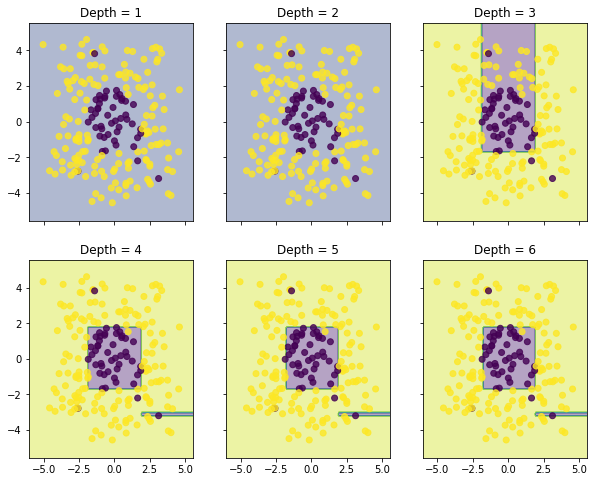

In [10]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [11]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

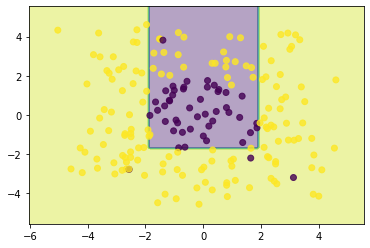

In [12]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], 
c=y_train_label[:,0], alpha=0.8)

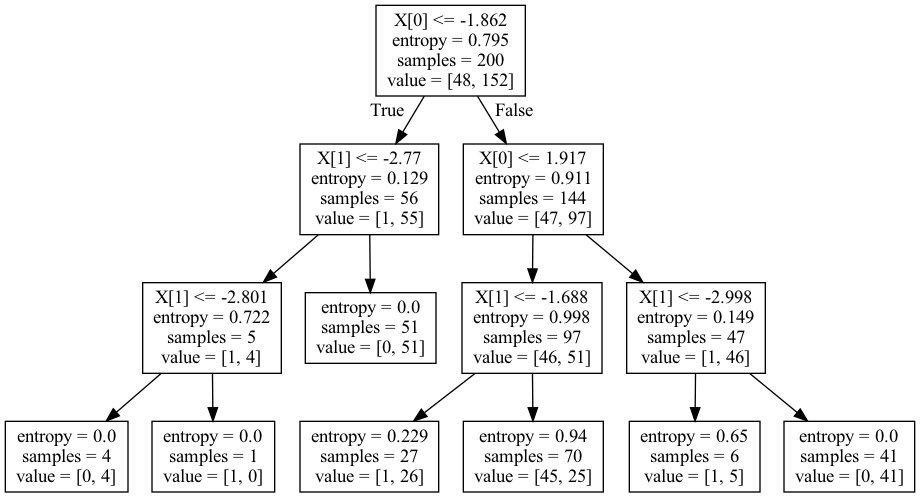

In [13]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png
Image(filename='tree_classifier.png')

# Decision Tree Regressor

In [14]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    #Calculate median
    median = np.median(y)
    
    #Calculate and return mean absolute deivation around median
    abs_diff = np.abs(y - median)
    mae = np.mean(abs_diff)
    return mae

In [15]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

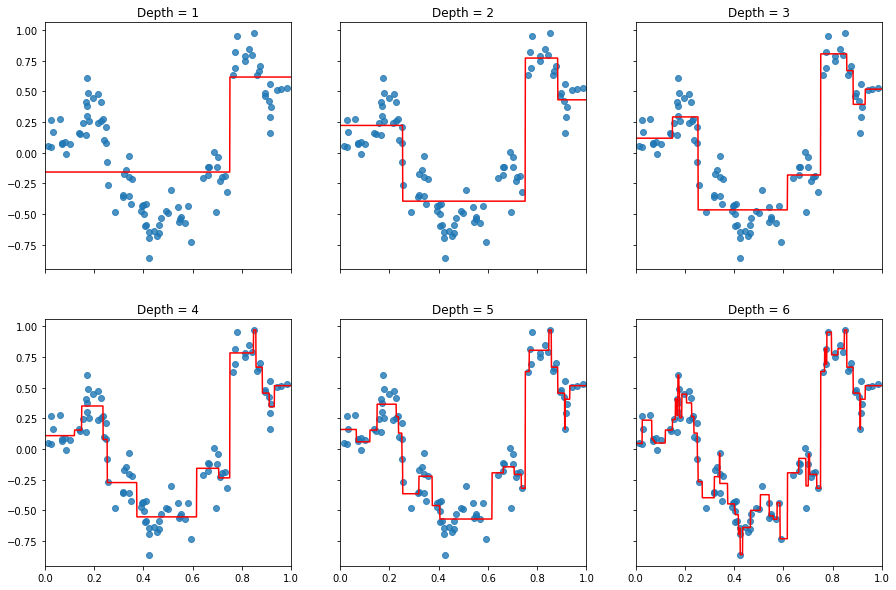

In [16]:
#Fit the Regression_Tree to the krr dataset using MAE loss and median predictions

data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=3, loss_function='mae', estimator='mean')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=3, loss_function='mae', estimator='mean')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=3, loss_function='mae', estimator='mean')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=3, loss_function='mae', estimator='mean')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=3, loss_function='mae', estimator='mean')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=10,  min_sample=3, loss_function='mae', estimator='mean')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Gradient Boosting Method

In [17]:
def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [18]:
def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict
def pseudo_residual_logistic(train_target,train_predict):
    y = train_target
    fx = train_predict
    m = y*fx
    return (y*np.exp(-m))/(1+np.exp(-m))

class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func,\
                 learning_rate=0.1, min_sample=5, max_depth=3):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth
        
        #Adding methods for base models (including initial model)
        self.base_models = []
        self.base_0 = None
        
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        '''
        #First fit base model
        self.base_0 = DecisionTreeRegressor(max_depth = self.max_depth,\
                                        min_samples_leaf = self.min_sample)
        self.base_0.fit(train_data, train_target)
        
        #Loop through each estimator
        estimator_range = self.n_estimator
        for step in range(estimator_range):
            
            #Predict step
            step_prediction = self.learning_rate * self.base_0.predict(train_data)
            
            #If there are no base models, use base_0 model to calculate residuals
            if len(self.base_models) == 0:
                residuals = self.pseudo_residual_func(train_target.reshape(-1),\
                                                      step_prediction)

            #Otherwise, loop through base models to calculate residuals
            else:
                base_model_range = len(self.base_models)
                for i in range(base_model_range):

                    #Calculate step prediction (weighted sum of predictions)
                    step_prediction += \
                    self.learning_rate * self.base_models[i].predict(train_data)
                    
                #Calculate residuals    
                residuals = self.pseudo_residual_func(train_target.reshape(-1)\
                                                      ,step_prediction)

            #Fit loss function to residuals, add to list of losses
            loss_func = DecisionTreeRegressor(max_depth = self.max_depth,\
                                       min_samples_leaf = self.min_sample)
            loss_func.fit(train_data,residuals)
            self.base_models.append(loss_func)   
    
    def predict(self, test_data):
        '''
        Predict value
        '''
        #Set step size, create prediction for base model
        step_size = 0.1
        test_predict = step_size * self.base_0.predict(test_data)
        
        #Loop through base models
        base_range = len(self.base_models)
        for model_i in range(base_range):
                        
            #Sum all base predictions to get step prediction
            test_predict += self.learning_rate*\
                            self.base_models[model_i].predict(test_data)
            
        return test_predict

# 1-D GBM visualization - KRR data

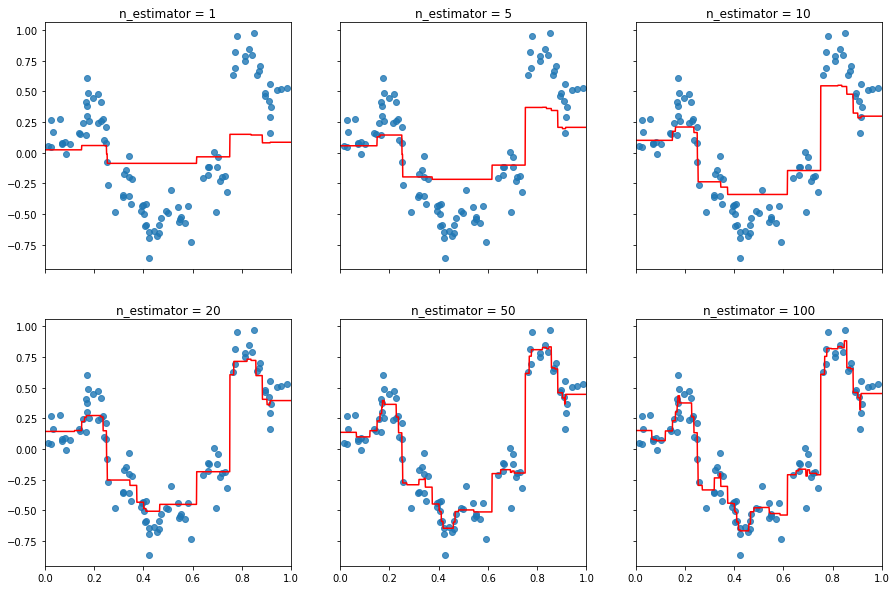

In [19]:
#Build gradient boosting models on the regression data

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

# Sklearn implementation for Classification of images

In [20]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

In [21]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1') 
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

In [22]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

In [23]:
#Plot train and test accuracy as a function of the number of estimators
n_estimator_list = [2, 5, 10, 100, 200]

train_accuracy_gbc = []
test_accuracy_gbc = []

for n_i in n_estimator_list:
    gbc = GradientBoostingClassifier(n_estimators=n_i, learning_rate=1.0, loss = 'deviance',
                                 max_depth=1, random_state=0).fit(X_train, y_train)
    train_accuracy_gbc.append(gbc.score(X_train, y_train))
    test_accuracy_gbc.append(gbc.score(X_test, y_test))

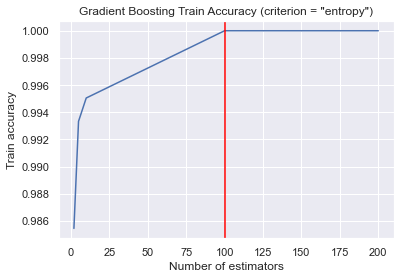

In [24]:
#Training accuracy

import seaborn as sns 
sns.set()
plt.plot(n_estimator_list, train_accuracy_gbc)
plt.xlabel('Number of estimators')
plt.ylabel('Train accuracy')
plt.title('Gradient Boosting Train Accuracy (criterion = "entropy")')

train_acc_gbc_max = np.max(train_accuracy_gbc)
train_acc_gbc_max_idx = train_accuracy_gbc.index(train_acc_gbc_max)
plt.axvline(x = n_estimator_list[train_acc_gbc_max_idx], color = 'red')

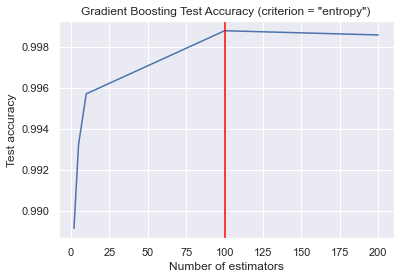

In [25]:
#Test accuracy
plt.plot(n_estimator_list, test_accuracy_gbc)
plt.xlabel('Number of estimators')
plt.ylabel('Test accuracy')
plt.title('Gradient Boosting Test Accuracy (criterion = "entropy")')

test_acc_gbc_max = np.max(test_accuracy_gbc)
test_acc_gbc_max_idx = test_accuracy_gbc.index(test_acc_gbc_max)
plt.axvline(x = n_estimator_list[test_acc_gbc_max_idx], color = 'red')

For random forest, a collection of trees is made where each node consists of a certain choice to split values between either branch. This is defined using a splitting variable that is set by a random subset of features from the data. This reduces the dependence between trees, and also lowers the likelihood of all trees being primarily influenced by a small subset of features. 

In [26]:
#Fit the preprocessed binary MNIST dataset

train_accuracy_rf = []
test_accuracy_rf = []

for n_i in n_estimator_list:
    rfc = RandomForestClassifier(n_estimators = n_i, max_depth = 3, criterion = 'entropy', random_state = 77)
    rfc.fit(X_train, y_train)
    train_accuracy_rf.append(rfc.score(X_train, y_train))
    test_accuracy_rf.append(rfc.score(X_test, y_test))

0.9981821854170875


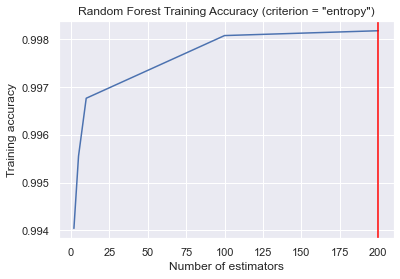

In [27]:
#Training accuracy
plt.plot(n_estimator_list, train_accuracy_rf)
plt.xlabel('Number of estimators')
plt.ylabel('Training accuracy')
plt.title('Random Forest Training Accuracy (criterion = "entropy")')

train_acc_rf_max = np.max(train_accuracy_rf)
train_acc_rf_max_idx = train_accuracy_rf.index(train_acc_rf_max)
plt.axvline(x = n_estimator_list[train_acc_rf_max_idx], color = 'red')

print(train_acc_rf_max)

0.998769987699877


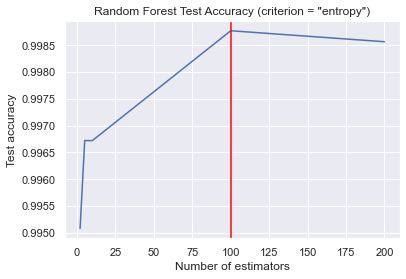

In [28]:
#Test accuracy
plt.plot(n_estimator_list, test_accuracy_rf)
plt.xlabel('Number of estimators')
plt.ylabel('Test accuracy')
plt.title('Random Forest Test Accuracy (criterion = "entropy")')

test_acc_rf_max = np.max(test_accuracy_rf)
test_acc_rf_max_idx = test_accuracy_rf.index(test_acc_rf_max)
plt.axvline(x = n_estimator_list[test_acc_rf_max_idx], color = 'red')

print(test_acc_rf_max)

Gradient boosted trees have the highest training accuracy for this MNIST datset. Gradient boosting reached 100% training accuracy on the training set using 100 estimators, while random forests only reached just over 99.8%. 

This is expected because gradient boosted trees have a very high model capacity, and as such, can model complicated decision boundaries. However, this can lead to overfitting, evidenced by a higher training accuracy than testing accuracy. As such, using a gradient boosted model with an excessive number of estimators could lead to overfitting and loss of generalization.

Based and test accuracies for the MNIST dataset, it would appear that random forest models are as accurate as gradient boosted trees (both around 99.88%).